In [1]:
import numpy as np
from glob import glob

np.random.seed(42)

import os
from multiprocessing import Pool, cpu_count

from src.helping import add_noise_2d, copy_sample, augment_sample

import matplotlib.pyplot as plt

from src.data_util import load_preprocess_examples
import seaborn as sns

In [15]:
hist_pig_dict = {}
load_path = "/data/PulHypStudie_Check_npz_v2/"

for P in ["P_{0:02d}_PulHyp".format(i) for i in range(1, 11)]:
    samples = len(os.listdir(load_path + P))
    hist_pig_dict[P] = samples
    print(P, samples)

P_01_PulHyp 10338
P_02_PulHyp 12859
P_03_PulHyp 8124
P_04_PulHyp 8914
P_05_PulHyp 10063
P_06_PulHyp 6934
P_07_PulHyp 5692
P_08_PulHyp 7189
P_09_PulHyp 8228
P_10_PulHyp 6552


In [3]:
Version = 5
SNR = 50

max_samples = 15_000
validation_limit = 500

In [4]:
try:
    os.mkdir(f"/data/PulHypStudie_Check_npz_v{Version}_SNR{SNR}")
except:
    print("Exists")

In [5]:
for P in range(1, 11):
    try:
        os.mkdir(
            f"/data/PulHypStudie_Check_npz_v{Version}_SNR{SNR}/"
            + "P_{0:02d}_PulHyp".format(P)
        )
    except BaseException:
        print("Skip", P)

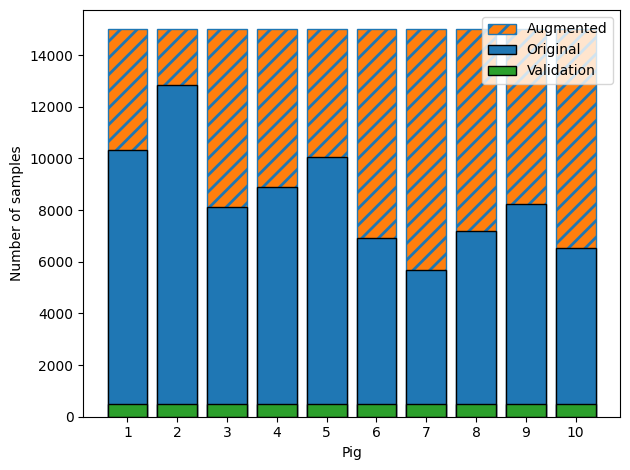

In [6]:
values = list(hist_pig_dict.values())

plt.rcParams["hatch.linewidth"] = 2
for i, v in enumerate(values):
    plt.bar(i, max_samples, color="C1", edgecolor="C0", hatch="//")
    plt.bar(i, v, color="C0", edgecolor="black")
    plt.bar(i, validation_limit, color="C2", edgecolor="black")
plt.xticks(ticks=np.arange(0, 10), labels=np.arange(1, 11))
plt.ylabel("Number of samples")
plt.xlabel("Pig")
plt.legend(["Augmented", "Original", "Validation"])
plt.tight_layout()
# plt.savefig("images/hist_pig_samples_aug_v2.png")
plt.show()

**Plot original data**

/data/PulHypStudie_Check_npz_v2/P_01_PulHyp/*.npz
10338


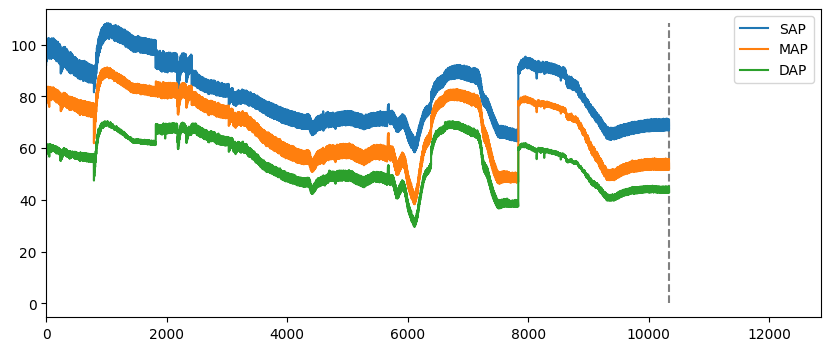

/data/PulHypStudie_Check_npz_v2/P_02_PulHyp/*.npz
12859


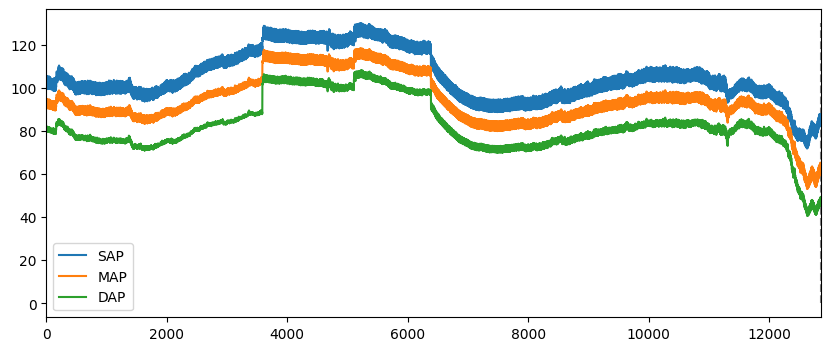

/data/PulHypStudie_Check_npz_v2/P_03_PulHyp/*.npz
8124


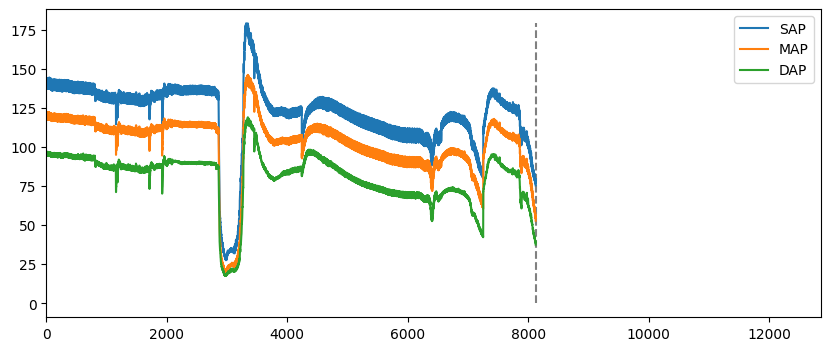

/data/PulHypStudie_Check_npz_v2/P_04_PulHyp/*.npz
8914


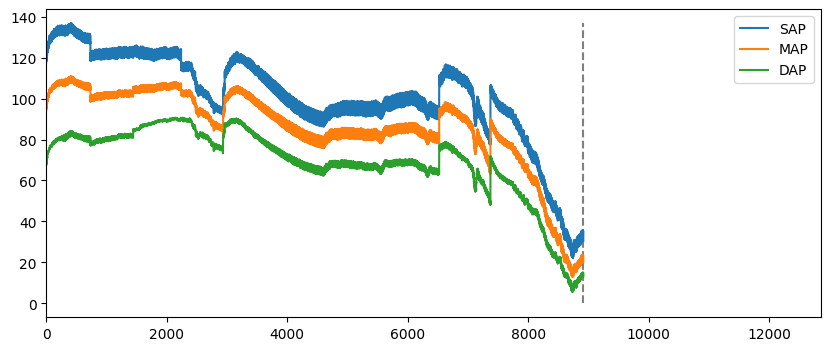

/data/PulHypStudie_Check_npz_v2/P_05_PulHyp/*.npz
10063


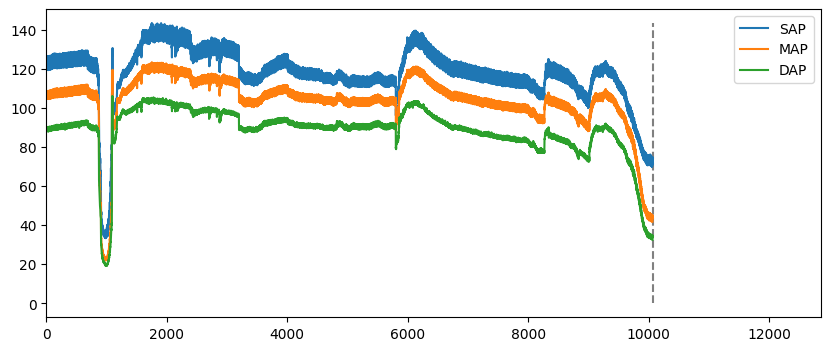

/data/PulHypStudie_Check_npz_v2/P_06_PulHyp/*.npz
6934


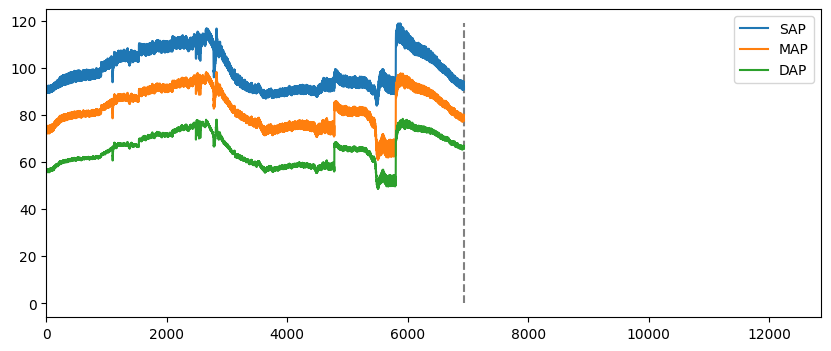

/data/PulHypStudie_Check_npz_v2/P_07_PulHyp/*.npz
5692


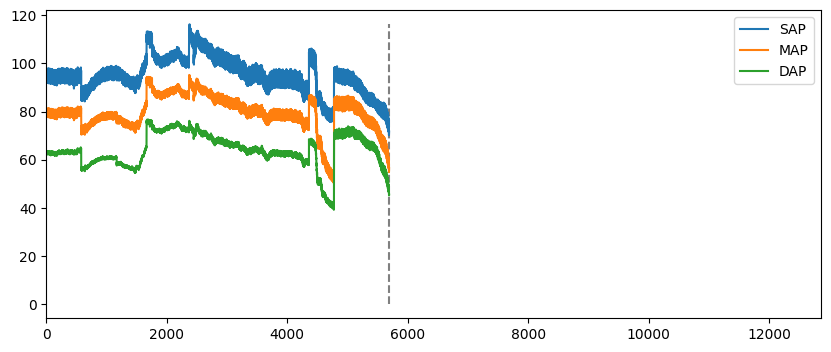

/data/PulHypStudie_Check_npz_v2/P_08_PulHyp/*.npz
7189


In [ ]:
for P in range(1, 11):
    A = list()
    source = f"/data/PulHypStudie_Check_npz_v2/"
    source += "P_{0:02d}_PulHyp/*.npz".format(P)
    print(source)
    fls = glob(source)
    print(len(fls))
    for ele in np.sort(fls):
        tmp = np.load(ele, allow_pickle=True)
        aorta = tmp["aorta"]
        A.append([np.min(aorta), np.max(aorta), np.mean(aorta)])
    A = np.array(A)
    plt.figure(figsize=(10, 4))
    plt.vlines(
        list(hist_pig_dict.values())[P - 1],
        ymin=0,
        ymax=np.max(A),
        colors="gray",
        linestyles="--",
    )
    plt.plot(A[:, 1], label="SAP")
    plt.plot(A[:, 2], label="MAP")
    plt.plot(A[:, 0], label="DAP")
    plt.xlim([0, 12859])
    plt.legend()
    plt.show()

## Augmentation

In [ ]:
os.cpu_count()

In [ ]:
for SELECTED_PIG in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    pig_path = ["P_{0:02d}_PulHyp".format(SELECTED_PIG)]
    print(pig_path)

    aug_path = f"/data/PulHypStudie_Check_npz_v{Version}_SNR{SNR}/" + pig_path[0] + "/"
    print(aug_path)
    X, y, clrs_pig = load_preprocess_examples(
        load_path,
        pig_path,
        sap=True,
        get_pig=True,
        shuffle=False,
        norm_eit="block",
        quality_check=False,
    )

    available = np.arange(0, X.shape[0])
    assert available.shape[0] == X.shape[0]

    print("available.shape=", available.shape, "X.shape=", X.shape)

    augmented = np.arange(X.shape[0], max_samples)
    aug_num = max_samples - X.shape[0]
    print(f"There are {X.shape[0]}, {aug_num} will be created.")

    sel_from_sample = np.random.randint(
        validation_limit, X.shape[0], size=aug_num
    )  # exclude the first validation_limit for validation
    sel_from_sample = np.sort(sel_from_sample)
    assert max_samples == len(available) + len(augmented)

    cpus = int(200)
    pool = Pool()
    for idx in available:
        pool.apply_async(
            copy_sample, args=(idx, X[idx, :, :, 0], y[idx], clrs_pig[idx], aug_path)
        )
    pool.close()

    cpus = int(200)
    pool = Pool()
    for i, idx in enumerate(augmented):
        pool.apply_async(
            augment_sample,
            args=(
                idx,
                X[sel_from_sample[i], :, :, 0],
                y[sel_from_sample[i]],
                clrs_pig[sel_from_sample[i]],
                aug_path,
            ),
        )
    pool.close()

**Plot augmented data**

In [ ]:
for P in range(1, 11):
    source = f"/data/PulHypStudie_Check_npz_v{Version}_SNR{SNR}/"
    source += "P_{0:02d}_PulHyp/*.npz".format(P)
    print(source)
    fls = glob(source)
    print(len(fls))

In [ ]:
for P in range(1, 11):
    A = list()
    source = f"/data/PulHypStudie_Check_npz_v{Version}_SNR{SNR}/"
    source += "P_{0:02d}_PulHyp/*.npz".format(P)
    print(source)
    fls = glob(source)
    print(len(fls))
    for ele in np.sort(fls):
        tmp = np.load(ele, allow_pickle=True)
        A.append(tmp["y"])
    A = np.array(A)
    plt.figure(figsize=(10, 4))
    plt.vlines(
        list(hist_pig_dict.values())[P - 1],
        ymin=0,
        ymax=np.max(A),
        colors="gray",
        linestyles="--",
    )
    plt.plot(A[:, 1], label="SAP")
    plt.plot(A[:, 2], label="MAP")
    plt.plot(A[:, 0], label="DAP")
    plt.legend()
    plt.show()

**Data loading evaluation**

In [ ]:
from src.data_util import load_augmented_example
from src.helping import find_pig_indices
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
aug_path = f"/data/PulHypStudie_Check_npz_v{Version}_SNR{SNR}/"
pigs = ["P_02_PulHyp"]

In [ ]:
for P in range(1, 11):
    pigs = "P_{0:02d}_PulHyp".format(P)
    print("Pig", pigs)
    X_train, y_train, clrs_pig_train = load_augmented_example(
        aug_path, [pigs], sample_skip=500, load_samples="upwards", shuffle=True
    )

    X_valid, y_valid, clrs_pig_valid = load_augmented_example(
        aug_path, [pigs], sample_skip=500, load_samples="downwards", shuffle=True
    )
    find_pig_indices(clrs_pig_train, "Pig_{0:02d}".format(P))
    find_pig_indices(clrs_pig_valid, "Pig_{0:02d}".format(P))
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(
        X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
    )

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    colors = [
        "red" if i < hist_pig_dict[pigs] else "green" for i in range(X_pca.shape[0])
    ]

    plt.figure(figsize=(8, 6))
    plt.title(f"EIT-PCA for pig {P}")
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors)
    plt.xlabel("1st principal component")
    plt.ylabel("2nd principal component")
    plt.show()

**Archive**

In [16]:
tmp.files

['eit', 'y', 'pig']

In [21]:
### Offset test

In [22]:
tmp = np.load(
    "/data/PulHypStudie_Check_npz_v4_SNR30/P_01_PulHyp/sample_000000.npz",
    allow_pickle=True,
)
tmp.files

['eit', 'y', 'pig']

___